In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import nltk

from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer


In [ ]:
#pip install 

In [16]:
#pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [3]:
#import data
df = pd.read_csv("Reviews.csv")

In [4]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
#Basic Information shape and columns
print(df.columns)
print(df.shape)

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')
(568454, 10)


In [6]:
# Product based collaborative filtering
#compute the count and mean value as group by the products
count = df.groupby("ProductId", as_index=False).count()
mean = df.groupby("ProductId", as_index=False).mean()

#merge two dataset create df1
df1 = pd.merge(df, count, how='right', on=['ProductId'])

#rename column
df1["Count"] = df1["UserId_y"]
df1["Score"] = df1["Score_x"]
df1["Summary"] = df1["Summary_x"]

#Create New dataframe with selected variables
df1 = df1[['ProductId','Summary','Score',"Count"]]

In [7]:
df1.head()

,ProductId,Summary,Score,Count
0,0006641040,Read it once. Read it twice. Reading Chicken S...,4,37
1,0006641040,Family favorite,5,37
2,0006641040,Disappointed,3,37
3,0006641040,"You'll use it once, you'll use it twice",5,37
4,0006641040,"The story is great, the softcover book is disa...",1,37


In [8]:
#choose only products have over 100 reviews
df1 = df1.sort_values(by=['Count'], ascending=False)
df2 = df1[df1.Count >= 100]

In [9]:
#create new dataframe as combining all summary with same product Id
df4 = df.groupby("ProductId", as_index=False).mean()
combine_summary = df2.groupby("ProductId")["Summary"].apply(list)
combine_summary = pd.DataFrame(combine_summary)
combine_summary.to_csv("combine_summary.csv")

In [10]:
#create with certain columns
df3 = pd.read_csv("combine_summary.csv")
df3 = pd.merge(df3, df4, on="ProductId", how='inner')
df3 = df3[['ProductId','Summary','Score']]

In [11]:
#Text Clean process - Summary column
#function for tokenizing summary
cleanup_re = re.compile('[^a-z]+')
def cleanup(sentence):
    sentence = sentence.lower()
    sentence = cleanup_re.sub(' ', sentence).strip()
    sentence = " ".join(nltk.word_tokenize(sentence))
    return sentence

In [13]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/liubovivashov/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [14]:
#reset index and drop duplicate rows
df3["Summary_Clean"] = df3["Summary"].apply(cleanup)
df3 = df3.drop_duplicates(['Score'], keep='last')
df3 = df3.reset_index()

In [15]:
from pandas import DataFrame 

docs = df3["Summary_Clean"] 
vect = CountVectorizer(max_features = 100, stop_words='english') 
X = vect.fit_transform(docs) 

df5 = DataFrame(X.A, columns=vect.get_feature_names())
df5 = df5.astype(int)

In [16]:
#save 
df5.to_csv("df5.csv")

In [17]:
# First let's create a dataset called X
X = np.array(df5)
 # create train and test
tpercent = 0.9
tsize = int(np.floor(tpercent * len(df5)))
df5_train = X[:tsize]
df5_test = X[tsize:]
#len of train and test
lentrain = len(df5_train)
lentest = len(df5_test)

In [18]:
#KNN classifier to find similar products
# Next we will instantiate a nearest neighbor object, and call it nbrs. Then we will fit it to dataset X.
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(df5_train)

# Let's find the k-neighbors of each point in object X. To do that we call the kneighbors() function on object X.
distances, indices = nbrs.kneighbors(df5_train)

In [21]:
#find most related products
for i in range(lentest):
    a = nbrs.kneighbors([df5_test[i]])
    related_product_list = a[1]
    
    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    third_related_product = [item[2] for item in related_product_list]
    third_related_product = str(third_related_product).strip('[]')
    third_related_product = int(third_related_product)
    
    print ("Based on product reviews, for ", df3["ProductId"][lentrain + i] ," and this average Score is ",df3["Score"][lentrain + i])
    print ("The first similar product is ", df3["ProductId"][first_related_product] ," and this average Score is ",df3["Score"][first_related_product])
    print ("The second similar product is ", df3["ProductId"][second_related_product] ," and this average Score is ",df3["Score"][second_related_product])
    print ("The third similar product is ", df3["ProductId"][third_related_product] ," and this average Score is ",df3["Score"][third_related_product])
    print ("-----------------------------------------------------------")

Based on product reviews, for  B007TGDXMU  and this average Score is  4.517006802721088
The first similar product is  B005ZBZLPI  and this average Score is  4.0
The second similar product is  B000SDKDM4  and this average Score is  4.08252427184466
The third similar product is  B001E50THY  and this average Score is  4.044642857142857
-----------------------------------------------------------
Based on product reviews, for  B007TGDXNO  and this average Score is  4.3478260869565215
The first similar product is  B007TGDXMK  and this average Score is  4.143540669856459
The second similar product is  B00451WLYI  and this average Score is  4.517647058823529
The third similar product is  B0001ES9F8  and this average Score is  4.302083333333333
-----------------------------------------------------------
Based on product reviews, for  B007TJGY5K  and this average Score is  4.119496855345912
The first similar product is  B007L3NVKU  and this average Score is  4.355072463768116
The second similar 

In [22]:
# Predicting Review Score
df5_train_target = df3["Score"][:lentrain]
df5_test_target = df3["Score"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(df5_train, df5_train_target)
knnpreds_test = knnclf.predict(df5_test)
print (knnpreds_test)

print(classification_report(df5_test_target, knnpreds_test))
print (accuracy_score(df5_test_target, knnpreds_test))

[4 4 4 3 4 4 3 3 3 4 4 3 3 3 4 4 4 3 3 3 4 3 4 3 4 3 4 4 4 4 4 4 3 4 3 4 3]
              precision    recall  f1-score   support

           3       0.50      0.80      0.62        10
           4       0.90      0.70      0.79        27

    accuracy                           0.73        37
   macro avg       0.70      0.75      0.70        37
weighted avg       0.80      0.73      0.74        37

0.7297297297297297


In [23]:
# User based collaborative filtering
count = df.groupby("UserId", as_index=False).count()
mean = df.groupby("UserId", as_index=False).mean()

#merge two dataset create df1
df1 = pd.merge(df, count, how='right', on=["UserId"])
#rename column
df1["Count"] = df1["ProductId_y"]
df1["Score"] = df1["Score_x"]
df1["Summary"] = df1["Summary_x"]

#Create New datafram with selected variables
df1 = df1[["UserId",'Summary','Score',"Count"]]

In [24]:
#choose only products have over 100 reviews
df1 = df1.sort_values(by=['Count'], ascending=False)
df2 = df1[df1.Count >= 100]

In [25]:
df4 = df.groupby("UserId", as_index=False).mean()
combine_summary = df2.groupby("UserId")["Summary"].apply(list)
combine_summary = pd.DataFrame(combine_summary)
combine_summary.to_csv("combine_summary.csv")

In [26]:
df3 = pd.read_csv("combine_summary.csv")
df3 = pd.merge(df3, df4, on="UserId", how='inner')
df3 = df3[['UserId','Summary','Score']]

In [27]:
df3["Summary_Clean"] = df3["Summary"].apply(cleanup)

In [28]:
df3 = df3.drop_duplicates(['Score'], keep='last')
df3 = df3.reset_index()

In [29]:
from pandas import DataFrame 
from sklearn.feature_extraction.text import CountVectorizer 
docs = df3["Summary_Clean"] 
vect = CountVectorizer(max_features = 100, stop_words='english') 
X = vect.fit_transform(docs) 
#print(DataFrame(X.A, columns=vect.get_feature_names()).to_string()) 
df5 = DataFrame(X.A, columns=vect.get_feature_names())
df5 = df5.astype(int)

In [30]:
df5.to_csv("df5.csv")
kkk  = df.drop_duplicates(['Summary'], keep='last')
kkk = kkk.reset_index()

In [31]:
#KNN classifier to find similar user and find their interesting products
# First let's create a dataset called X, with 6 records and 2 features each.
X = np.array(df5)

tpercent = 0.95
tsize = int(np.floor(tpercent * len(df5)))
df5_train = X[:tsize]
df5_test = X[tsize:]

lentrain = len(df5_train)
lentest = len(df5_test)

# Next we will instantiate a nearest neighbor object, and call it nbrs. Then we will fit it to dataset X.
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(df5_train)

# Let's find the k-neighbors of each point in object X. To do that we call the kneighbors() function on object X.
distances, indices = nbrs.kneighbors(df5_train)

In [32]:
#finding similar user and intereting products
for i in range(lentest):
    a = nbrs.kneighbors([df5_test[i]])
    related_product_list = a[1]
    
    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    third_related_product = [item[2] for item in related_product_list]
    third_related_product = str(third_related_product).strip('[]')
    third_related_product = int(third_related_product)
    
    print ("Based on  reviews, for user is ", df3["UserId"][lentrain + i])
    print ("The first similar user is ", df3["UserId"][first_related_product], ".") 
    print ("He/She likes following products")
    for i in range(295743):
        if (kkk["UserId"][i] == df3["UserId"][first_related_product]) & (kkk["Score"][i] == 5):
            aaa= kkk["ProductId"][i]
        
            print (aaa),
    print ("--------------------------------------------------------------------")

Based on  reviews, for user is  AY12DBB0U420B
The first similar user is  A3FKGKUCI3DG9U .
He/She likes following products
B007K449CE
B000EPUPSS
B000F4DKAS
B001OCBT3U
B000EMM9WG
B0014X5O1C
B004158VLU
B0018SMUVA
B004BKLHOS
B000F4J76E
B000YCJRIU
B008RWUHA6
B000MPQ4Q2
B000ETVRQS
B001E6IUMY
B000EMK4CS
B0027MIP9C
B001OCKIBY
B004FQU4CE
B000JVCBO8
B002LMXFCU
B007JT7ARQ
--------------------------------------------------------------------
Based on  reviews, for user is  AY1EF0GOH80EK
The first similar user is  AKMEY1BSHSDG7 .
He/She likes following products
B000E5AO8O
B0001UZTJG
B0009XQSAY
B000GWHFZA
B000WHPNI0
B001EQ55RW
B000EXMP74
B000NQ6TRY
B000FA38ZE
B000BLNU6E
B001EQ4J42
B00469PHX6
B000CQ4D3C
B001OCKI5U
B003ZXHB7E
B000STZRTW
B0007R9L4M
B000CBR2FS
B000E1FZJG
B000EXKS14
B0043OX51U
B001E5E060
B001EQ4HM6
B000OBYNQW
B000E1FZBY
B007TGO1U8
B000E67210
B000KNHFKU
B005G2FCNM
B0014X5O1C
B000YPMKY0
B000YW7Q0Q
B004BKLHOS
B000I60JUW
B001EQ4IKW
B001FA1KLW
B000FKQD5G
B000LKXNG2
B0014ET0OI
B000CQ4D50
B001M0

In [33]:
#Predicting Review Score
df5_train_target = df3["Score"][:lentrain]
df5_test_target = df3["Score"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(df5_train, df5_train_target)
knnpreds_test = knnclf.predict(df5_test)
print ("Predicting review score for testset user are : ", knnpreds_test)

print(classification_report(df5_test_target, knnpreds_test))

Predicting review score for testset user are :  [3 4 4 4]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       1.00      0.75      0.86         4

    accuracy                           0.75         4
   macro avg       0.50      0.38      0.43         4
weighted avg       1.00      0.75      0.86         4



/Users/liubovivashov/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liubovivashov/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liubovivashov/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
#Word correlation based on cluster
cluster = df.groupby("Score")["Summary"].apply(list)

In [35]:
cluster = pd.DataFrame(cluster)
cluster.to_csv("cluster.csv")
cluster1 = pd.read_csv("cluster.csv")

In [36]:
cluster1["Summary_Clean"] = cluster1["Summary"].apply(cleanup)

In [37]:
cluster1.head()

,Score,Summary,Summary_Clean
0,1,"['Not as Advertised', 'My Cats Are Not Fans of...",not as advertised my cats are not fans of the ...
1,2,"['Cough Medicine', 'poor taste', 'Taste is not...",cough medicine poor taste taste is not so good...
2,3,"['Hearty Oatmeal', 'Mushy', 'Same stuff', 'not...",hearty oatmeal mushy same stuff not ass kickin...
3,4,"['""Delight"" says it all', 'Nice Taffy', 'fresh...",delight says it all nice taffy fresh and greas...
4,5,"['Good Quality Dog Food', 'Great taffy', 'Grea...",good quality dog food great taffy great just a...


# Create wordcloud based on summary and score

In [39]:
from nltk.corpus import stopwords

In [51]:
conda install -c conda-forge wordcloud

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.11.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/liubovivashov/opt/anaconda3

  added / updated specs:
    - wordcloud


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.11.0               |   py39h6e9494a_0        16.9 MB  conda-forge
    python_abi-3.9             |           2_cp39           4 KB  conda-forge
    wordcloud-1.8.1            |   py39h89e85a6_2         172 KB  conda-forge
    ------------------------------------------------------------
                                           Total:        17.1 MB

The following NEW packages will be INSTALLED:

  python_abi         conda-forge/osx-64::python_abi-3.9-2_cp39
  wordcloud          conda-forge/osx-64::wordclo

In [53]:
from wordcloud import WordCloud

In [54]:
import re
import string
from wordcloud import WordCloud, STOPWORDS

In [55]:
#World Clouding for Each Score Group

stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=500,
        max_font_size=30, 
        scale=3,
        random_state=1 
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

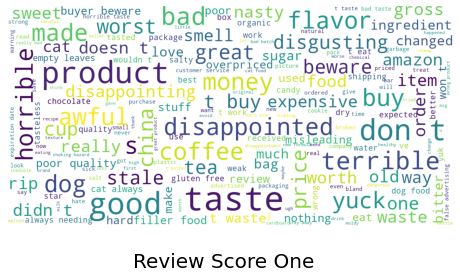

In [56]:
show_wordcloud(cluster1["Summary_Clean"][0], title = "Review Score One")

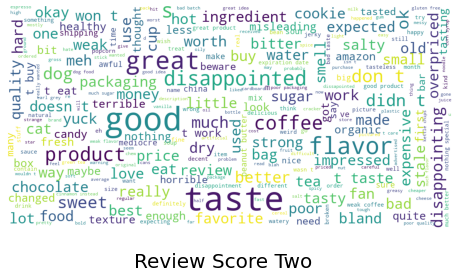

In [57]:
show_wordcloud(cluster1["Summary_Clean"][1] , title = "Review Score Two")

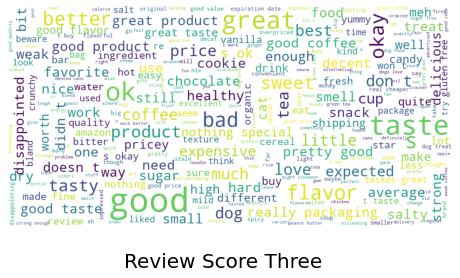

In [58]:
show_wordcloud(cluster1["Summary_Clean"][2], title = "Review Score Three")

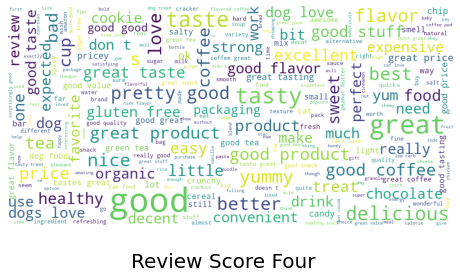

In [59]:
show_wordcloud(cluster1["Summary_Clean"][3], title = "Review Score Four")

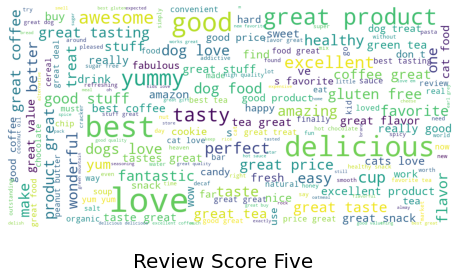

In [60]:
show_wordcloud(cluster1["Summary_Clean"][4], title = "Review Score Five")